In [ ]:
import numpy as np
import pandas as pd
import os
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Dataset Classificação Binária (Gato e não gato)

In [ ]:
with ZipFile('./drive/MyDrive/Colab Notebooks/notebooks-estudo/dados_teste_DL/dogs-vs-cats.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [ ]:
path_dataset = './dogs-vs-cats'
 
dataset_files = os.listdir(path_dataset)
labels = []
 
for file in dataset_files:
    label = file.split('.')[1]
    if label == 'Cat':
        labels.append('Cat')
    else:
        labels.append('Dog')
        
dataset_df = pd.DataFrame({'file_names': dataset_files, 'labels': labels})
dataset_df.head(5)

,file_names,labels
0,4314.Cat.jpg,Cat
1,4111.Dog.jpg,Dog
2,10967.Cat.jpg,Cat
3,3153.Cat.jpg,Cat
4,8295.Cat.jpg,Cat


In [ ]:
datagen=ImageDataGenerator(rescale=1./255)
dataset =datagen.flow_from_dataframe(dataframe=dataset_df, target_size=(28,28) ,directory=path_dataset, x_col="file_names",y_col="labels", class_mode="categorical",batch_size=3000,seed=1)
 
X,y_b=dataset.next() # X[photo x size_y x size_x x RBG] e y[photo x binary_class_2_bits]
 
print ("dataset feature shape: " + str(X.shape))
print ("dataset target shape: " + str(y_b.shape))

Found 25000 validated image filenames belonging to 2 classes.
dataset feature shape: (3000, 28, 28, 3)
dataset target shape: (3000, 2)


In [ ]:
X_flatten = X.reshape(X.shape[0], -1) 
X_flatten.shape

(3000, 2352)

In [ ]:
y = np.zeros([y_b.shape[0],1])
y[:,0] = y_b[:,0] # colapsar binary_class de 2 bits para 1 bit considerando classificação gato=1, não_gato=0
y=y
y.shape

(3000, 1)

In [ ]:
train_x_orig, test_x_orig, train_y, test_y = train_test_split(X_flatten, y, random_state=0, test_size=0.20)

In [ ]:
train_x = train_x_orig.T
test_x = test_x_orig.T
train_y = train_y.T
test_y = test_y.T
 
 
print ("train_x shape: " + str(train_x.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x shape: " + str(test_x.shape))
print ("test_y shape: " + str(test_y.shape))

train_x shape: (2352, 2400)
train_y shape: (1, 2400)
test_x shape: (2352, 600)
test_y shape: (1, 600)


# Dataset Classificação Multiclass (10 tipos de roupas)

In [ ]:
(train_x_orig, train_y_orig), (test_x_orig, test_y_orig) = fashion_mnist.load_data()

In [ ]:
train_x_flatten_df = pd.DataFrame(train_x_orig.reshape(train_x_orig.shape[0], -1)/255)   # The "-1" makes reshape flatten the remaining dimensions
print ("train_x flattem shape: " + str(train_x_flatten_df.shape))

train_x flattem shape: (60000, 784)


In [ ]:
train_y_df = pd.DataFrame(train_y_orig)
print ("train_y_df  shape: " + str(train_y_df.shape))

train_y_df  shape: (60000, 1)


In [ ]:
train_y_df.value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
dtype: int64

In [ ]:
train_dataset= pd.concat([train_x_flatten_df,train_y_df], axis=1)
train_dataset.shape

(60000, 785)

In [ ]:
train_dataset_sample=train_dataset.sample(1000)
train_dataset_sample.shape

(1000, 785)

In [ ]:
train_x=np.array((train_dataset_sample.iloc[:,0:-1]).T)
train_x.shape

(784, 1000)

In [ ]:
(train_dataset_sample.iloc[:,-1]).value_counts()

8    111
5    108
2    107
4    106
6    105
3     99
0     99
9     93
7     91
1     81
Name: 0, dtype: int64

In [ ]:
train_y_dec = np.zeros([1,train_dataset_sample.shape[0]])
train_y_dec[0,:]=np.array((train_dataset_sample.iloc[:,-1]).T)
train_y_dec.shape

(1, 1000)

In [ ]:
lb = preprocessing.LabelBinarizer()
lb.fit([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
train_y=lb.transform(train_y_dec.T)
train_y=train_y.T
train_y.shape

(10, 1000)

In [ ]:
test_x = (test_x_orig.reshape(test_x_orig.shape[0], -1)/255).T
print ("train_x flattem shape: " + str(test_x.shape))

train_x flattem shape: (784, 10000)


In [ ]:
test_y_dec = np.zeros([1,test_y_orig.shape[0]])
test_y_dec[0,:]= test_y_orig
test_y_dec.shape

(1, 10000)

In [ ]:
lb = preprocessing.LabelBinarizer()
lb.fit([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
test_y=lb.transform(test_y_dec.T)
test_y=test_y.T
test_y.shape

(10, 10000)

 # Hiperparametros: Número de camadas e neurônios por camada

In [ ]:
n_x = train_x.shape[0] #tamanho da camada de entrada
n_h1 = 16 # escolha de numero de neuronios na primeira camada escondida
n_h2 = 16
n_y =  train_y.shape[0] 
layers_dims = (n_x,n_h1,n_h2, n_y)

# Modelo

## Inicialização dos parametros W e b

In [ ]:
def initialize_parameters_deep(layer_dims):
 
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network
 
    for l in range(1, L): # para inicialização de W e b varrer camada 1 para frente (camada 0 é entrada e não possui pesos e bias)
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01 # W[n(l) x n(l-1)]
        parameters['b' + str(l)] = np.zeros([layer_dims[l],1]) # b[n(l) x 1]
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
 
       
    return parameters

## Forward Propagation

### Calculando combinação linear dos pesos z = WX + b

In [ ]:
def linear_forward(A, W, b):
  
    Z = np.dot(W,A) + b # ((W[n(l) x n(l-1)] * A[n(l-1) x m])[n(l) x m] + b[n(l) x 1])[n(l) x m]
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

### Inserindo não linearidade a função z (função de ativação)

In [ ]:
 
def sigmoid(z): 
    return 1/(1 + np.exp(-z)) , z # Z[n(l) x m] e A[n(l) x m]
 
def relu(z):
   return np.maximum(0,z) , z # Z[n(l) x m] e A[n(l) x m]
 
def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b) # Z[n(l) x m] 
        A, activation_cache = sigmoid(Z) # A[n(l) x m]
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b) # Z[n(l) x m]
        A, activation_cache = relu(Z) # A[n(l) x m]
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
 
    return A, cache

### Potencializando a não linearidade com camadas ocultas

In [ ]:
def L_model_forward(X, labels, parameters):
 
    caches = []
    A = X
    L = len(parameters) // 2  # number of layers in the neural network
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)],parameters['b' + str(l)], "relu")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)],parameters['b' + str(L)], "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (labels,X.shape[1]))
            
    return AL, caches

### Calculando a função de custo para avaliar o erro entre a saída do modelo e os labels do dataset

In [ ]:
def compute_cost(AL, Y):
   
    m = Y.shape[1]
    
    cost = np.sum((-1/(m))*np.sum(np.multiply(np.log(AL),Y) + np.multiply(np.log(1-AL),1-Y), axis=1 )) # Um valor real
  
    cost = np.squeeze(cost) 
    assert(cost.shape == ())
    
    return cost

## Backward Propagation 
Encontrar derivada da função perdão em relação a dW e db em cada camada que serão utilizados no gradiente descendente para obter os valores ótimos de W e b das L camadas do modelo


In [ ]:
def sigmoid_backward(dA, cache):
  
    Z = cache # Z[n(l) x m]
    s = 1/(1+np.exp(-Z)) # s[n(l) x m]
    dZ = dA * s * (1-s) # dA[n(l) x m]
    return dZ
 
def relu_backward(dA, cache):
 
    Z = cache
    # just converting dz to a correct object.
    dZ = np.array(dA, copy=True)
    # When z <= 0, we should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    return dZ #dZ[n(l) x m]
 
def linear_backward(dZ, cache):
   
    A_prev, W, b = cache #Z_prev
    m = A_prev.shape[1]
 
    dW = (1/m)*(np.dot(dZ,A_prev.T)) # (dZ[n(l) x m] * A_prev[m x n(l-1)].T)[n(l) x n(l-1)] = W[n(l) x n(l-1)]
    db = (1/m)*(np.sum(dZ, axis=1, keepdims=True)) # soma por linha de dZ[n(l) x m], ou seja, soma todos os exemplos em cada dZ (derivada da entrada de cada neurônio na camada l em questão) resultando em db[n(l) x 1]
    dA_prev = np.dot(W.T,dZ)# (W[n(l-1) x n(l)].T * dZ[n(l) x m])[n(l-1) x m]
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db 
 
def linear_activation_backward(dA, cache, activation):
  
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db # dA[n(l-1) x m], dW[n(l) x n(l-1)], db[n(l) x 1]
 
 
def L_model_backward(AL, Y, caches):
  
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL

    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1] #ultima camada
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
 
    return grads

## Gradiente Descendente 

Iterativamente busca-se encontrar os valores de W e b onde o gradiente da função perda em relação a W e b é mínimo, neste ponto temos os valores otimos de W e b. O gradiente descendente se apoia em uma operação vetorial de subtração, pois o gradiente negativo da função de perda em relação a W e b aponta para o minimo local da função perda. A cada soma iterativa de um ponto  W com um vetor gradiente negativo -dL/dW e um ponto b com o gradiente negativo -dL/db gera um novo ponto W e b  mais proximo do minimo local da função perda

In [ ]:
def update_parameters(parameters, grads, learning_rate):
    
    L = len(parameters) // 2 
    # number of layers in the neural network. Para uma rede de 1 camada profunda temos quatro parametros: W1,b1,W2,b2, 
    # sendo assim temos 2 camadas (oculta e saida pois a camada de entrada não possui peso e não deve ser considerada)
 
    for l in range(L): # in range começa em l=0
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l+1)]

    return parameters

## Integrando forward/backward propogation + gradiente descendente dentro das iterações de ajustes de W e b

In [ ]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.01, num_iterations = 3000, print_cost=False):
   
    np.random.seed(1)
    grads = {}
    costs = []  # to keep track of the cost
    m = X.shape[1]
    labels = layers_dims[-1]    
    
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, labels, parameters)

        cost = compute_cost(AL, Y) # para duas camadas compute_cost deveria receber A2

        grads =L_model_backward(AL, Y, caches)
       
        parameters = update_parameters(parameters, grads, learning_rate = learning_rate)

        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

# Rodando Modelo para obter  parâmetros ótimos 

Ajuste de Hiperparamentos: learning_rate e numero de iterações

Cost after iteration 0: 0.6931469796095343
Cost after iteration 100: 0.6930998119667059
Cost after iteration 200: 0.6930956042790353
Cost after iteration 300: 0.6930948021825954
Cost after iteration 400: 0.6930943141882161
Cost after iteration 500: 0.6930938004551308
Cost after iteration 600: 0.6930932555320221
Cost after iteration 700: 0.6930926099190227
Cost after iteration 800: 0.6930918276677576
Cost after iteration 900: 0.693090689044433
Cost after iteration 1000: 0.6930893116090651
Cost after iteration 1100: 0.6930879184664385
Cost after iteration 1200: 0.693086372079606
Cost after iteration 1300: 0.6930844358778423
Cost after iteration 1400: 0.6930821402339982
Cost after iteration 1500: 0.6930794595823893
Cost after iteration 1600: 0.693076292639535
Cost after iteration 1700: 0.6930724132606847
Cost after iteration 1800: 0.6930676931390836
Cost after iteration 1900: 0.6930619063661685
Cost after iteration 2000: 0.6930546330983455
Cost after iteration 2100: 0.693045338583654
Cost

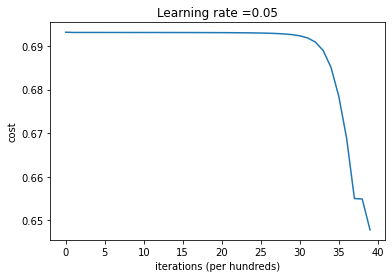

In [ ]:
parameters = L_layer_model(train_x, train_y, layers_dims,learning_rate=0.05, num_iterations = 4000, print_cost=True)

# Implementando função preditiva (L_model_forward + parâmetros ótimos)

In [ ]:
def predict(X, labels, parameters):
    
    AL, caches = L_model_forward(X, labels,parameters)
    p = np.zeros(AL.shape)  
    id_col_max_by_line=np.argmax((AL), axis=0) # guarda em um vetor de tamanho m o index da coluna de cada sample com maior valor
    for i in range(AL.shape[1]-1):# varredura por samples
        p[id_col_max_by_line[i],i]=1 # pega o id da coluna com maior valor do  sample i no vetor id_col_max_by_line e atribui o valor 1 a essa coluna do sample i
   
    return p

# Medindo acurácia de treino

In [ ]:
print("train accuracy: {} %".format(100 - np.mean(np.sum(np.abs(predict(train_x,train_y.shape[0], parameters) - train_y),axis=0)) * 100))
# quando sum(predict(train_x, parameters) - train_y) igual a 0 significa que o modelo acertou pois ao fazer a diferença coluna a coluna de labels entre a predição e y podemos encontras os seguintes cenários:
# 1- As colunas de uma linha da matriz predição com valor igual a 1 coincidirem com as colunas com valor 1 da mesma linha na matriz y. A diferença de todas as colunas igual 0. Somando todas as colunas temos um valor final igual a o
# Quando a lógica acima resultar em um valor final igual a 1, o modelo errou. O valor da média significa o percentual de erro, pois considera a soma dos resultados igual a 1. 
# Para encontrar o valor de acurracy é so subitrair o valor total (100%) do valor do erro.

train accuracy: 49.541666666666664 %


# Medindo acurária de teste

In [ ]:
print("train accuracy: {} %".format(100 - np.mean(np.sum(np.abs(predict(test_x,test_y.shape[0], parameters) - test_y),axis=0)) * 100))

train accuracy: 51.5 %
